In [125]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression

#additional libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import cross_validate


# annoying warnings
import warnings
warnings.filterwarnings('ignore')

#additional libraries, Payman
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
import glob
np.random.seed(42)

In [126]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

In [127]:
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)


### XGBRegressor

**Without sampling**

In [128]:
xgb_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test

    xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15)
    

    xgb_fit = xgb_ml.fit(X_train, y_train)
    xgb_preds = xgb_fit.predict(X_val)
#     print(xgb_ml.feature_importances_)
    
    mae = mean_absolute_error(y_val, xgb_preds)
    mse = mean_squared_error(y_val, xgb_preds)
    r_squared = r2_score(y_val, xgb_preds)
    
    xgb_dict[str(file)] = {}
    xgb_dict[str(file)]['mae'] = mae
    xgb_dict[str(file)]['mse'] = mse
    xgb_dict[str(file)]['r_squared'] = r_squared
    xgb_dict[str(file)]['feat_imp'] = xgb_ml.feature_importances_
    
    
#     print("MAE: {:.{}f}".format(mae, 2))
#     print("MSE: {:.{}f}".format(mse, 2))
#     print("R-squared: {:.{}f}".format(r_squared, 2))
    

In [129]:
xgb_df = pd.DataFrame.from_dict(xgb_dict)

**With sampling**

In [130]:
xgb_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15)
        
        xgb_fit = xgb_ml.fit(X_train, y_train)
        xgb_preds = xgb_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, xgb_preds)
        mse = mean_squared_error(y_val, xgb_preds)
        r_squared = r2_score(y_val, xgb_preds)
        
        xgb_s_dict[str(file) + '_w' + str(w)] = {}
        xgb_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        xgb_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        xgb_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        xgb_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = xgb_ml.feature_importances_


#         print("MAE: {:.{}f}".format(mae, 2))
#         print("MSE: {:.{}f}".format(mse, 2))
#         print("R-squared: {:.{}f}".format(r_squared, 2))

In [131]:
xgb_s_df = pd.DataFrame.from_dict(xgb_s_dict)

In [132]:
xgb_summ = pd.concat([xgb_df.T, xgb_s_df.T])

In [133]:
xgb_summ['Model'] = 'XGB'

### RandomForestRegressor

In [134]:
#get best hyper parameters for the model
# hyperparameters = {
#     'n_estimators': range(90, 201, 10),
#     'max_depth': range(2, 12, 2),
#     'min_samples_split' : range(2, 10, 2),
#     'min_samples_leaf' : list(range(1, 10, 1))
# #     'min_weight_fraction_leaf' : (0.0)
#                               }

# grid = GridSearchCV(base_model, param_grid=hyperparameters, n_jobs=-1)
# grid.fit(X_train, y_train)
# print('score = {}\nparams={}'.format(grid.best_score_, grid.best_params_))

**Without sampling**

In [135]:
rf_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                    min_samples_split = 9,min_samples_leaf = 4,
                    min_weight_fraction_leaf= 0.0)
    
    rf_fit = rf_reg.fit(X_train, y_train)
    rf_reg_preds = rf_fit.predict(X_val)
    
    mae = mean_absolute_error(y_val, rf_reg_preds)
    mse = mean_squared_error(y_val, rf_reg_preds)
    r_squared = r2_score(y_val, rf_reg_preds)
    
    rf_dict[str(file)] = {}
    rf_dict[str(file)]['mae'] = mae
    rf_dict[str(file)]['mse'] = mse
    rf_dict[str(file)]['r_squared'] = r_squared
    rf_dict[str(file)]['feat_imp'] = rf_reg.feature_importances_
    


In [136]:
rf_df = pd.DataFrame.from_dict(rf_dict)

**With sampling**

In [137]:
rf_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                        min_samples_split = 9,min_samples_leaf = 4,
                        min_weight_fraction_leaf= 0.0)

        rf_fit = rf_reg.fit(X_train, y_train)
        rf_reg_preds = rf_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, rf_reg_preds)
        mse = mean_squared_error(y_val, rf_reg_preds)
        r_squared = r2_score(y_val, rf_reg_preds)
        
        rf_s_dict[str(file) + '_w' + str(w)] = {}
        rf_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        rf_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        rf_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        rf_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = rf_reg.feature_importances_

In [138]:
rf_s_df = pd.DataFrame.from_dict(rf_s_dict)

In [139]:
rf_summ = pd.concat([rf_df.T, rf_s_df.T])

In [140]:
rf_summ['Model'] = 'RandomForest'

In [141]:
model_summ = pd.concat([xgb_summ, rf_summ])

In [142]:
model_summ

,feat_imp,mae,mse,r_squared,Model
no_tempinc.csv,"[0.012207469, 0.013006349, 0.7322356, 0.010226...",0.612694,0.962303,0.705246,XGB
no_tempinc_minmax.csv,"[0.0043219067, 0.0, 0.004733006, 0.9217876, 0....",0.0278662,0.001611,0.720345,XGB
no_tempinc_standard.csv,"[0.002517537, 0.0, 0.00288609, 0.88501984, 0.0...",0.35664,0.347604,0.600739,XGB
tempinc.csv,"[0.009270809, 0.009607556, 0.78790265, 0.00438...",0.70424,1.21886,0.67412,XGB
tempinc_minmax.csv,"[0.0038226065, 0.0, 0.002877083, 0.91679627, 0...",0.0290195,0.0027729,0.621984,XGB
tempinc_standard.csv,"[0.0013814281, 0.0, 0.0018894186, 0.9435775, 0...",0.402176,0.512975,0.556111,XGB
no_tempinc.csv_w1,"[0.018961001, 0.012710622, 0.72244096, 0.01029...",0.667499,1.02595,0.661455,XGB
no_tempinc.csv_w3,"[0.0037152858, 0.0028405625, 0.94186664, 0.002...",0.638193,0.8906,0.706118,XGB
no_tempinc.csv_w5,"[0.0035773078, 0.0036005103, 0.94718516, 0.001...",0.645333,0.882803,0.708691,XGB
no_tempinc_minmax.csv_w1,"[0.0032606525, 0.0, 0.004483474, 0.9209425, 0....",0.0299552,0.00379433,0.490006,XGB


In [143]:
model_summ.sort_values(by = 'r_squared', ascending=False)

,feat_imp,mae,mse,r_squared,Model
no_tempinc_minmax.csv,"[0.0043219067, 0.0, 0.004733006, 0.9217876, 0....",0.0278662,0.001611,0.720345,XGB
no_tempinc.csv_w5,"[0.0035773078, 0.0036005103, 0.94718516, 0.001...",0.645333,0.882803,0.708691,XGB
no_tempinc.csv_w3,"[0.0037152858, 0.0028405625, 0.94186664, 0.002...",0.638193,0.8906,0.706118,XGB
no_tempinc.csv,"[0.012207469, 0.013006349, 0.7322356, 0.010226...",0.612694,0.962303,0.705246,XGB
tempinc_standard.csv_w1,"[0.0037931504, 0.0, 0.004644645, 0.9039884, 0....",0.359193,0.294903,0.701696,XGB
tempinc_standard.csv_w3,"[0.0036582793, 0.0, 0.0047528283, 0.90470815, ...",0.354727,0.297384,0.699186,XGB
tempinc.csv_w3,"[0.005797037, 0.0061094123, 0.87533855, 0.0044...",0.691277,1.13257,0.693798,XGB
tempinc_minmax.csv_w1,"[0.002338941, 0.0, 0.0023245416, 0.90684587, 0...",0.029826,0.00229038,0.68316,XGB
tempinc.csv_w1,"[0.00899829, 0.008351728, 0.77662575, 0.007496...",0.699491,1.20329,0.67468,XGB
tempinc.csv,"[0.009270809, 0.009607556, 0.78790265, 0.00438...",0.70424,1.21886,0.67412,XGB


# Model interpretation

Focusing in on RandomForest, decided to use MAE as the metric for interpretability. 




In [144]:
#Filter to RandomForest results and sort by MAE instead
model_summ[model_summ.Model == 'RandomForest'].sort_values(by = 'mae', ascending=False)

,feat_imp,mae,mse,r_squared,Model
tempinc.csv_w5,"[0.07755972508097696, 0.10632750694907947, 0.0...",0.814744,1.37864,0.52386,RandomForest
tempinc.csv_w3,"[0.07720081727755217, 0.09772257083087102, 0.0...",0.780863,1.27584,0.559364,RandomForest
no_tempinc.csv_w5,"[0.1097034352293717, 0.07344947172808772, 0.06...",0.766215,1.22513,0.642793,RandomForest
tempinc.csv_w1,"[0.05180250447714357, 0.08491601231761829, 0.0...",0.756377,1.15868,0.599828,RandomForest
tempinc.csv,"[0.059786736322408156, 0.06853497459170974, 0....",0.750778,1.24777,0.575696,RandomForest
no_tempinc.csv_w3,"[0.09331348905035158, 0.0731330640184389, 0.04...",0.736402,1.12796,0.671127,RandomForest
no_tempinc.csv_w1,"[0.06115995469566545, 0.07794401577420683, 0.0...",0.722235,1.30237,0.620273,RandomForest
no_tempinc.csv,"[0.0661930723229124, 0.06947252567026754, 0.10...",0.715699,1.37586,0.536928,RandomForest
tempinc_standard.csv_w1,"[0.03841658948969329, 0.0377404429931127, 0.07...",0.40676,0.420561,0.577854,RandomForest
no_tempinc_standard.csv_w1,"[0.02369970487105127, 0.026177989243932085, 0....",0.405308,0.447798,0.582053,RandomForest


In the above table, some MAE and RMSE values are less than 0.1. We deem these erroneous as we do not expect our models to have such high accuracy. Furthermore, those results are well below the acceptable range for MAE for our domain. Focusing in on the valid results, the best model MAE is the 'no_tempinc_standard.csv' case at ~0.39, with resonable RMSE of ~0.35 and R-squared value of ~0.59. This model does not incorporate sampling weights or the new temperature increas variables, however it does scale the variables using the StandardScaler function in SKlearn. We will proceed with this model and apply the test set for interpretation. 


In [219]:
#Run final model for analysis:
#For this version, we're going to introduce a random column to the training set to detect whether any features fall below it.
np.random.seed(42) #somehow this needs to be re-declared here. Not sure why.
df = pd.read_csv('../p_data/no_tempinc_standard.csv')
train, val, test = np.split(df.sample(frac=1), 
                            [int(.6*len(df)), 
                             int(.8*len(df))])

y_train = train['Quality']
train.drop(['Quality'], axis = 1, inplace = True)
X_train = train
X_train['Random'] = np.random.random(size=len(X_train))

y_val = val['Quality']
val.drop(['Quality'], axis = 1, inplace = True)
X_val = val
X_val['Random'] = np.random.random(size=len(X_val))

y_test = test['Quality']
test.drop(['Quality'], axis = 1, inplace = True)
X_test = test
X_test['Random'] = np.random.random(size=len(X_test))

rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                min_samples_split = 9,min_samples_leaf = 4,
                min_weight_fraction_leaf= 0.0)

rf_fit = rf_reg.fit(X_train, y_train)
rf_reg_preds_val = rf_fit.predict(X_val)
rf_reg_preds_test = rf_fit.predict(X_test)

mae = mean_absolute_error(y_test, rf_reg_preds_test)
mse = mean_squared_error(y_test, rf_reg_preds_test)
r_squared = r2_score(y_test, rf_reg_preds_test)
print("Test set MAE:",mae)

mae = mean_absolute_error(y_val, rf_reg_preds_val)
mse = mean_squared_error(y_val, rf_reg_preds_val)
r_squared = r2_score(y_val, rf_reg_preds_val)
print("Validation set MAE:",mae)

#Can't match the original MAE results. Why?? Is the sampling different??
#Unnamed columns

display(X_test)

Test set MAE: 0.440191763648489
Validation set MAE: 0.38269430755805944


,Unnamed: 0,Unnamed: 0.1,Main_Mass_Flow,Additive_1_Ratio,Additive_2_Ratio,Additive_3_Ratio,Additive_4_Ratio,Additive_5_Ratio,Additive_6_Ratio,Flow_Gas_Ratio,...,T_Zone_5,T_Zone_6,T_Zone_7,T_Zone_8,T_Zone_9,T_Zone_10,Blending,CampaignID,Campaign.Hrs,Random
928,928,-0.520831,0.046784,0.440326,1.174619,-0.305998,-0.400528,-1.129761,0.305998,-0.040026,...,0.112583,0.208203,0.301672,0.326710,0.347708,0.969147,0.736654,-0.16329,0.351978,0.482713
823,823,-0.659164,-0.219730,0.440326,-0.019969,-0.305998,-0.400528,-1.129761,0.305998,-0.091170,...,0.381588,1.114192,1.208121,1.265719,1.083913,-0.138300,0.736654,-0.16329,-0.178616,0.777455
1531,1531,0.255372,0.761520,0.440326,1.793503,-0.305998,2.663635,0.958063,0.305998,0.382880,...,0.031381,-0.161140,-0.241842,-0.106172,0.070133,0.933535,0.736654,0.51935,-0.888279,0.672847
1214,1214,-0.151942,1.511302,0.440326,-0.596667,-0.305998,-0.400528,-1.129761,0.305998,-0.095310,...,-0.120994,-0.402725,-0.390699,-0.414602,-0.383394,0.357058,0.736654,-0.16329,1.633329,0.724255
504,504,-1.069041,-1.410146,0.440326,0.570298,-0.305998,-0.400528,-1.129761,0.305998,2.657551,...,0.353725,0.599705,0.823428,0.826301,-0.115690,-1.474451,0.736654,-0.84593,-1.071692,0.492599
2631,2631,1.692501,1.743774,0.440326,-1.160258,-0.305998,-0.184100,0.958063,0.305998,0.015339,...,-0.532527,-1.428776,-1.735792,-1.743777,-1.667341,-0.485075,-2.095634,1.20199,0.897940,0.633412
1996,1996,0.866344,1.266188,0.440326,-0.880073,-0.305998,-0.184100,0.958063,0.305998,-0.115731,...,-0.354014,-1.300047,-1.401066,-1.289302,-0.900620,0.423874,0.736654,0.51935,1.180376,0.805526
1958,1958,0.815110,1.262581,0.440326,-0.880073,-0.305998,-0.184100,0.958063,0.305998,-0.050316,...,-0.272349,-0.930683,-1.105913,-1.128480,-1.163180,-1.200629,0.736654,0.51935,1.014536,0.397884
1384,1384,0.065805,0.538600,0.440326,-0.019969,-0.305998,-0.400528,0.958063,0.305998,0.437603,...,0.011849,0.031703,0.054291,-0.069253,-0.003524,0.248515,0.736654,-0.16329,2.314595,0.805979
894,894,-0.565661,-0.807961,0.440326,0.252360,-0.305998,-0.400528,-1.129761,0.305998,-0.114906,...,0.813866,1.322129,1.265854,1.363274,1.436957,1.581898,0.736654,-0.16329,0.174646,0.592017


### Default RandomForest feature_importance analysis

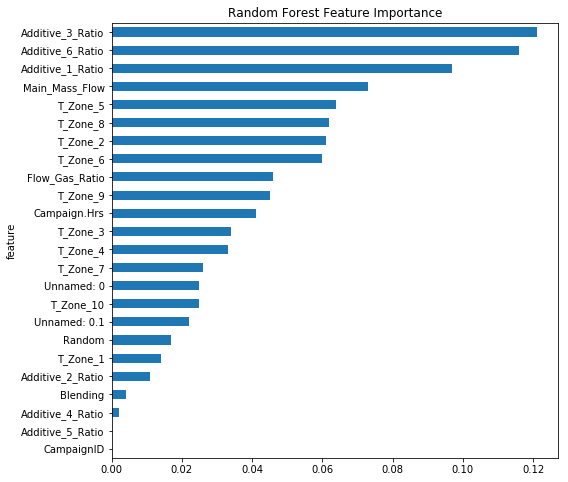

In [221]:
#Obtain feature importances from the model result and join back to features:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_reg.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Feature Importance")
#Reasonable results, random column is at the lower end of the scale

### Permutation importance analysis

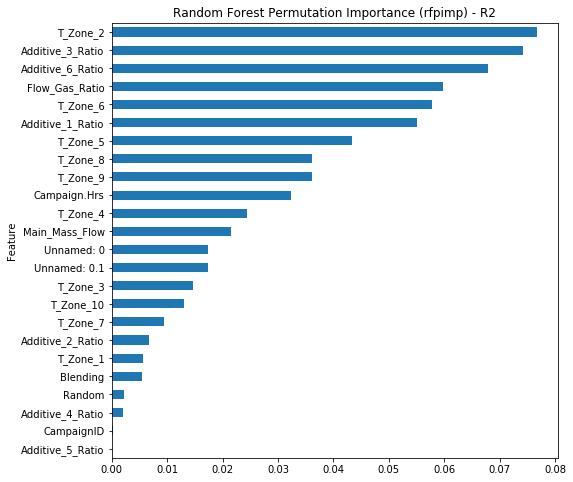

In [222]:
from rfpimp import permutation_importances

def mae(rf, X_val, y_val):
    return mean_absolute_error(y_val, rf.predict(X_val))

def r2(rf, X_val, y_val):
    return r2_score(y_val, rf.predict(X_val))

perm_imp_rfpimp = permutation_importances(rf_reg, X_val, y_val, r2)
perm_imp_rfpimp = perm_imp_rfpimp.sort_values('Importance',ascending=True)
perm_imp_rfpimp.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance (rfpimp) - R2")
#importance goes negative when I switch the function to mae to evaluate. Why?

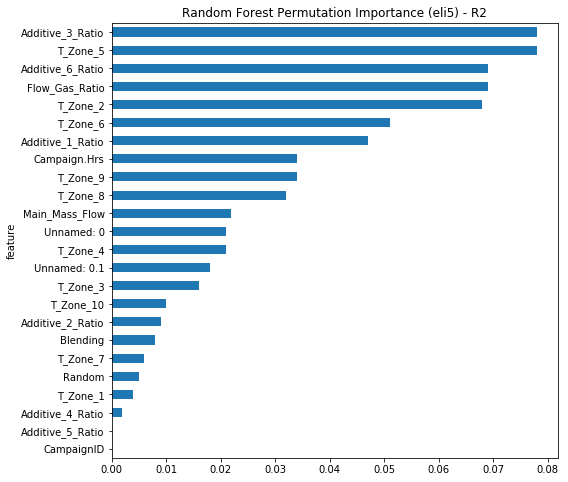

In [223]:
#Try different package:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_reg, cv = "prefit", n_iter = 50).fit(X_val, y_val)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(perm.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance (eli5) - R2")
#Result is very close to rfpimp implementation with r2 score, up to the Top 5. Minor variations below that.

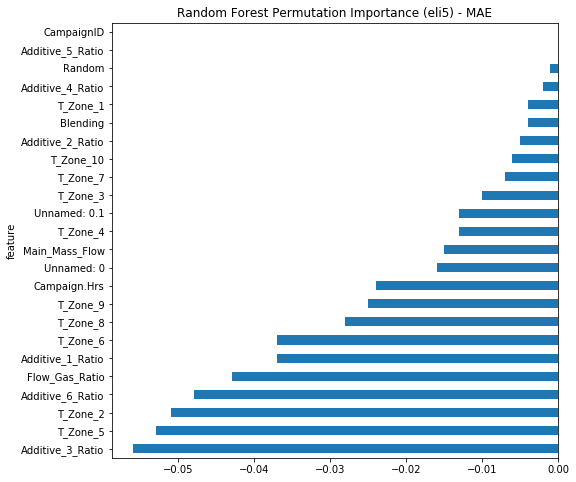

In [224]:
#Change scoring to mae:
perm = PermutationImportance(rf_reg, cv = "prefit", n_iter = 50, scoring=mae).fit(X_val, y_val)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(perm.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance (eli5) - MAE")
#whyyyyy

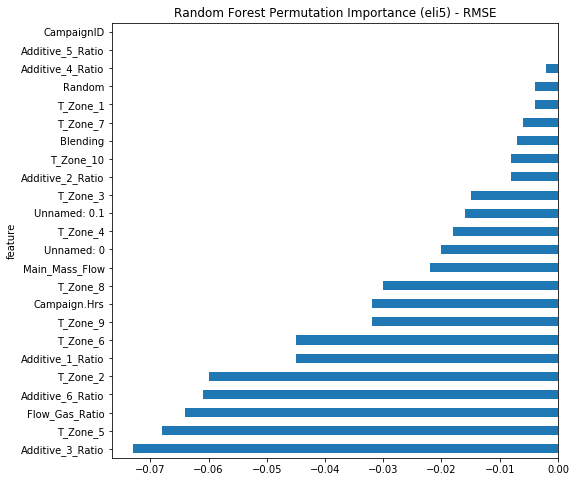

In [226]:
#Change scoring to RMSE:
def rmse(rf, X_val, y_val):
    return mean_squared_error(y_val, rf.predict(X_val))

perm = PermutationImportance(rf_reg, cv = "prefit", n_iter = 50, scoring=rmse).fit(X_val, y_val)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(perm.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance (eli5) - RMSE")
#negative PI still....smh